<a href="https://colab.research.google.com/github/GitHrsh/5G-NR_Resource_Allocation/blob/main/Wireless_Network_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8  # Speed of light in m/s

In [ ]:
# Numerologies (example values)
numerologies = {
    'eMBB': {
        'subcarrier_spacing': 30e3,  # 30 kHz
        'symbol_duration': 1 / (30e3 * 14),  # symbol duration
        'slot_duration': 1 / (30e3 * 14) * 14  # slot duration
    },
    'URLLC': {
        'subcarrier_spacing': 60e3,  # 60 kHz
        'symbol_duration': 1 / (60e3 * 14),
        'slot_duration': 1 / (60e3 * 14) * 14
    }
}

In [ ]:
# Base Station Parameters
base_station = {
    'frequency': 3.5e9,  # 3.5 GHz
    'bandwidth': 100e6,  # 100 MHz
    'tx_power': 40,  # in dBm
    'antenna_gain': 15,  # in dBi
    'location': np.array([0, 0])  # Base station at the origin
}

In [ ]:
ue = {
    'location': np.array([0.0, 0.0]),  # Initial location of the UE (x, y coordinates)
    'speed': 10,  # Speed of the UE in meters per second
    'direction': np.pi / 4  # Direction of movement
}

In [ ]:
def cost_hata(distance, frequency, base_height, ue_height, environment='urban'):
    """
    Cost Hata Path Loss Model
    Parameters:
    - distance: Distance between UE and Base Station (in km)
    - frequency: Carrier frequency (in MHz)
    - base_height: Height of the base station antenna (in meters)
    - ue_height: Height of the UE antenna (in meters)
    - environment: Type of environment ('urban', 'suburban', 'open')
    """
    distance_km = distance / 1000  # Convert distance to km
    frequency_mhz = frequency / 1e6  # Convert frequency to MHz

    if environment == 'urban':
        a_h = (1.1 * np.log10(frequency_mhz) - 0.7) * ue_height - (1.56 * np.log10(frequency_mhz) - 0.8)
        path_loss = (69.55 + 26.16 * np.log10(frequency_mhz)
                     - 13.82 * np.log10(base_height)
                     - a_h
                     + (44.9 - 6.55 * np.log10(base_height)) * np.log10(distance_km))
    elif environment == 'suburban':
        path_loss = cost_hata(distance, frequency, base_height, ue_height, 'urban') - 2 * (np.log10(frequency_mhz / 28)) ** 2 - 5.4
    elif environment == 'open':
        path_loss = cost_hata(distance, frequency, base_height, ue_height, 'urban') - 4.78 * (np.log10(frequency_mhz)) ** 2 + 18.33 * np.log10(frequency_mhz) - 40.94

    return path_loss

def calculate_snr_cost_hata(tx_power, distance, frequency, bandwidth, base_height, ue_height):
    """ Calculate SNR using Cost Hata Path Loss Model """
    path_loss = cost_hata(distance, frequency, base_height, ue_height)
    received_power = tx_power - path_loss
    noise_power = -174 + 10 * np.log10(bandwidth)  # Thermal noise in dBm
    return received_power - noise_power


In [ ]:
def update_average_rate(prev_rate, current_rate, alpha):
    """ Update the average data rate for a UE using the given formula. """
    return alpha * prev_rate + (1 - alpha) * current_rate

def objective_function_proportional_fairness(x, data_rates, avg_rates, num_users, num_rbs):
    """
    Custom objective function to maximize proportional fairness.

    Parameters:
    - x: Decision matrix flattened as an array.
    - data_rates: Matrix of max data rates (r_ij) for each UE and RB.
    - avg_rates: Array of average rates (R_i) for each UE.
    - num_users: Number of UEs.
    - num_rbs: Number of RBs.
    """
    x = x.reshape((num_users, num_rbs))
    objective_value = 0

    epsilon = 1e-6  # Small constant to avoid division by zero

    for i in range(num_users):
        rate_sum = np.sum(x[i, :] * data_rates[i, :]) / (avg_rates[i] + epsilon)
        objective_value += np.log(rate_sum)

    return -objective_value  # Negative because we're minimizing in the optimizer


In [ ]:
def optimize_rb_allocation_proportional_fairness(data_rates, avg_rates, num_rbs, alpha):
    """
    Optimize RB allocation using the custom objective function for proportional fairness.

    Parameters:
    - data_rates: Matrix of max data rates (r_ij) for each UE and RB.
    - avg_rates: Array of average rates (R_i) for each UE.
    - num_rbs: Total number of RBs available.
    - alpha: Value for updating average rates.
    """
    from scipy.optimize import minimize

    num_users = data_rates.shape[0]

    # Initial allocation (equal RBs for each UE)
    initial_allocation = np.ones((num_users, num_rbs)) / num_rbs
    initial_allocation = initial_allocation.flatten()

    # Bounds for RB allocation (0 or 1 for each x_ij)
    bounds = [(0, 1) for _ in range(num_users * num_rbs)]

    # Constraints (each RB can only be allocated to one UE)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x.reshape((num_users, num_rbs)), axis=0) - 1}]

    # Optimization
    result = minimize(objective_function_proportional_fairness, initial_allocation,
                      args=(data_rates, avg_rates, num_users, num_rbs),
                      bounds=bounds, constraints=constraints, method='SLSQP')

    return result.x.reshape((num_users, num_rbs))  # Optimized decision matrix


In [ ]:
def shannon_capacity(bandwidth, snr):
    """ Shannon Capacity formula to calculate the maximum data rate """
    snr_linear = 10 ** (snr / 10)
    return bandwidth * np.log2(1 + snr_linear)

In [ ]:
def simulate_movement_with_proportional_fairness(ue, base_station, duration, timestep, total_rbs, alpha):
    """ Simulate UE movement with proportional fairness RB allocation over time """
    times = np.arange(0, duration, timestep)
    snr_values = []
    data_rates = []
    avg_rates = np.zeros(1)  # Adjusted for a single UE
    locations = []  # To track UE positions

    for t in times:
        # Update UE position
        ue['location'] += ue['speed'] * timestep * np.array([np.cos(ue['direction']), np.sin(ue['direction'])])
        distance = np.linalg.norm(ue['location'] - base_station['location'])

        # Track the position
        locations.append(ue['location'].copy())

        # Calculate SNR using Cost Hata
        snr = calculate_snr_cost_hata(base_station['tx_power'], distance, base_station['frequency'],
                                      base_station['bandwidth'], base_height=30, ue_height=1.5)
        snr_values.append(snr)

        # Max data rates for each RB (r_ij)
        max_data_rate = shannon_capacity(base_station['bandwidth'] / total_rbs, snr)
        data_rate_matrix = np.ones((1, total_rbs)) * max_data_rate

        # Optimize RB allocation and calculate data rates
        decision_matrix = optimize_rb_allocation_proportional_fairness(data_rate_matrix, avg_rates, total_rbs, alpha)
        current_rate = np.sum(decision_matrix * data_rate_matrix)

        # Update average rate
        avg_rates[0] = update_average_rate(avg_rates[0], current_rate, alpha)
        data_rates.append(current_rate)

    return times, snr_values, data_rates, np.array(locations)


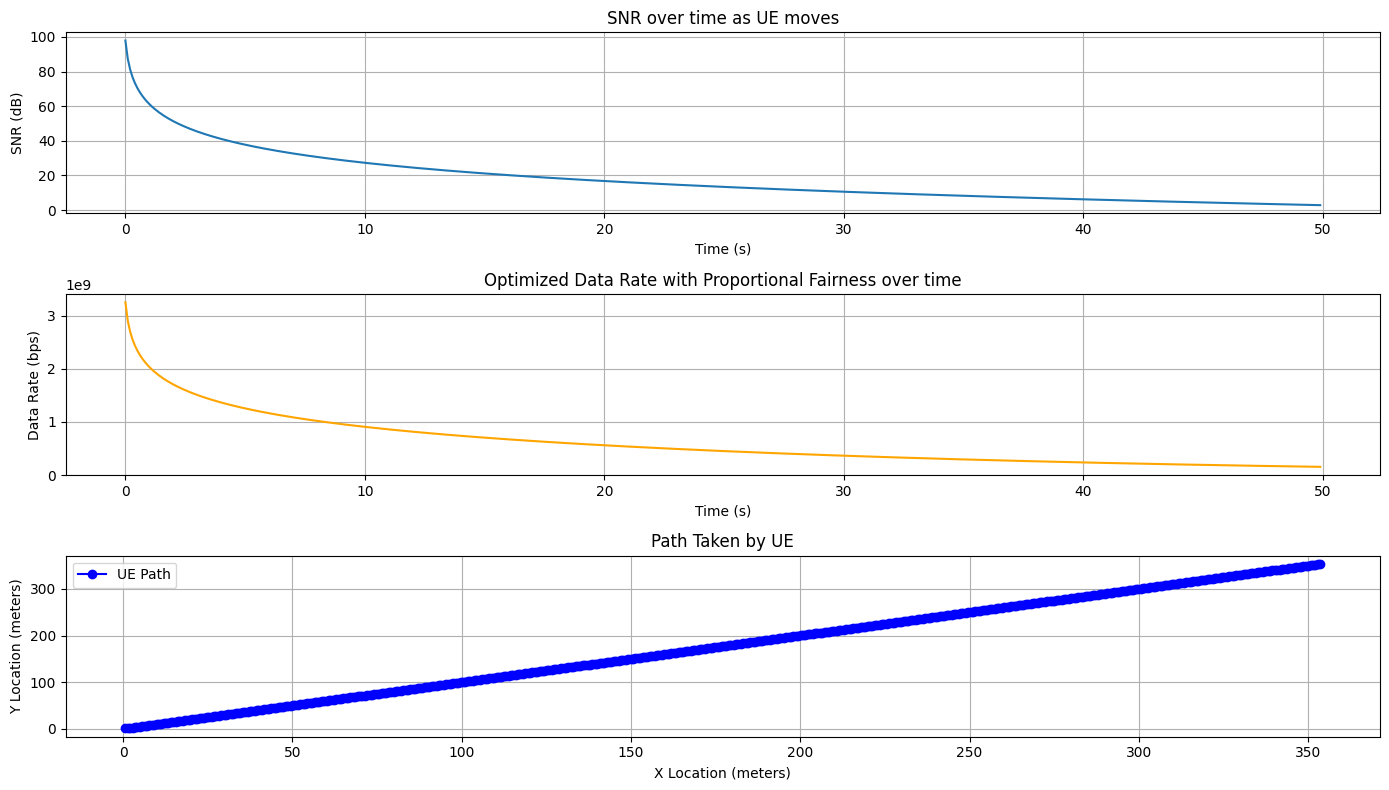

In [ ]:
# Run the simulation
times, snr_values, data_rates, locations = simulate_movement_with_proportional_fairness(
    ue, base_station, duration=50, timestep=0.1, total_rbs=100, alpha=0.9)

# Plot SNR and Data Rates
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(times, snr_values, label='SNR (dB)')
plt.xlabel('Time (s)')
plt.ylabel('SNR (dB)')
plt.title('SNR over time as UE moves')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(times, data_rates, label='Data Rate (bps)', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Data Rate (bps)')
plt.title('Optimized Data Rate with Proportional Fairness over time')
plt.grid(True)

# Plot UE path
plt.subplot(3, 1, 3)
plt.plot(locations[:, 0], locations[:, 1], marker='o', linestyle='-', color='b', label='UE Path')
plt.xlabel('X Location (meters)')
plt.ylabel('Y Location (meters)')
plt.title('Path Taken by UE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
